In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# Define a Web Scraper which will get dcouments from Medium.com for a given topic
def mediumScraper(topic):
    links = []
    content = []
    
    response = requests.get('https://medium.com/topic/'+topic)
    soup = BeautifulSoup(response.text,'lxml')
    
    for post in soup.findAll("a", { "data-action" : "open-post" }):
        links.append(post['href'].split('?')[0])
    
    for link in links:
        response2 = requests.get(link)
        soup2 = BeautifulSoup(response2.text,'lxml')
        paragraphs = ''
        for paragraph in soup2.findAll("p", { "class" : "graf graf--p graf-after--p" }):
            paragraphs += paragraph.text

        content.append(paragraphs)
        print('Found one document on topic %s' %(topic))
        
    return pd.DataFrame({'topic':topic,'links':links,'content':content},columns=['topic','links','content'])    

In [2]:
# Choose 8 topics
topics = ['data-science','politics','technology','sexuality','artificial-intelligence','culture','software-engineering','equality']
df = mediumScraper(topics[0])
for topic in topics[1:]:
    df = pd.concat([df,mediumScraper(topic)],ignore_index=True)
    print('Documents loaded for topic %s; Ready to scrape the next one.' %(topic))


Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one document on topic data-science
Found one docume

In [6]:
# Back up the original data frame just in case
df_bk = df

In [7]:
# Remove empty doucment and we have the same number of documents for each topic, just for the convenience of comparison
#df['topic'].value_counts()
#df[df['content']=='']
df.drop(df.index[[26,44]],inplace=True)
df.reset_index(inplace=True)

In [ ]:
# Import NTLK and download stopword
import nltk
nltk.download('stopwords')

In [27]:
# Define a fucntion which will print top N words in each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Define a function which will plot word cloud for top N words in each topic
from wordcloud import WordCloud
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

def plot_word_cloud(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        ind = topic.argsort()[:-n_top_words - 1:-1]
        tf_dict = {}
        for i in ind:
            tf_dict[feature_names[i]] = topic[i]
        # Create wordcloud object from the TF dictionary
        wordcloud = WordCloud(background_color="white")
        wordcloud.generate_from_frequencies(frequencies=tf_dict)

        plt.figure()
        plt.title('Topic #%s' %(topic_idx))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

# Define a fucntion which will plot doucment topic as a image
def plot_document_topic(model, documents_matrix, n_document_per_topic):
    document_id = []
    topic_id = []
    topic_score = []
    document_count = documents_matrix.shape[0]
    for i in range(0,document_count):
        document_id.append(i)
        topic_id.append(model.transform(documents_matrix)[i].argmax())
        topic_score.append(model.transform(documents_matrix)[i].max())
    
    document_topic = pd.DataFrame({'document_id':document_id,'topic_id':topic_id,'topic_score':topic_score})
    document_topic_img = document_topic['topic_id'].values.reshape(document_count/n_document_per_topic,n_document_per_topic)
    plt.figure()
    plt.imshow(document_topic_img)
    plt.axis("off")
    return document_topic

In [44]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []
for i in range(0,200):
    # Tokenization
    # Remove any character except letters
    # Convert into lower case
    content = re.sub('[^a-zA-Z]',' ',df['content'][i]).lower()
    # Convert into stem word
    ps = PorterStemmer()
    content = ' '.join([ps.stem(word) for word in content.split(' ') if not word in set(stopwords.words('english'))])
    corpus.append(content)
    
# Fit LDA model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from time import time

cv = CountVectorizer(max_features=2000)
t0 = time()
X = cv.fit_transform(corpus)
print("TF conversion done in %0.3fs." % (time() - t0))

t0 = time()
lda = LatentDirichletAllocation(n_topics=8, max_iter=10,
                                learning_method='online')
lda.fit(X)
print("LDA done in %0.3fs." % (time() - t0))
lda_feature_names = cv.get_feature_names()


TF conversion done in 0.163s.
LDA done in 1.403s.


In [45]:
# Examine LDA model
# Print Top 20 words for 8 topics
print_top_words(lda, lda_feature_names, 20)

Topic #0:
cultur touch hipster contact physic suppli cat locat paper clip maxim paperclip human men make map sexual platon power chain
Topic #1:
car vehicl autonom drive technolog use self transact standard global av connect also year safeti card see billion map imag
Topic #2:
peopl shame sexual standard relationship may person sex one accept pornographi use like white mani cultur social alic exclus abl
Topic #3:
like one peopl time would work get want even make women way need thing use men know us feel say
Topic #4:
senat bill vote health repeal would presid devic request care time use republican iot govern need data amend one elector
Topic #5:
data use user vr make strategi visual event also compani get code function stream read time technolog model differ tool
Topic #6:
anim tool game charact design ai motion wide varieti complex train cloth recent deep learn simul model creat machin advanc
Topic #7:
trump one power anti peopl world white right jew state year presid would semit us a

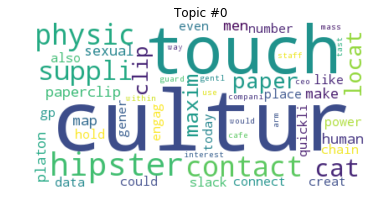

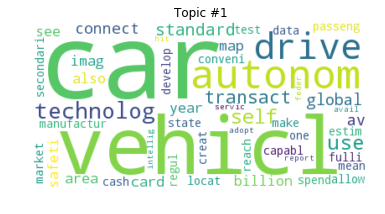

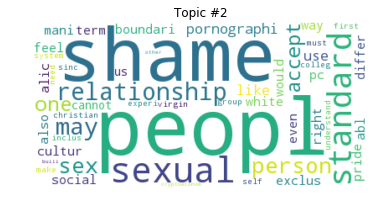

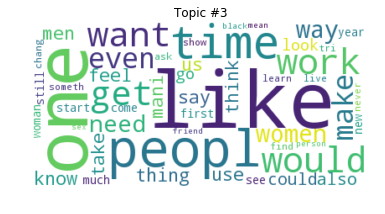

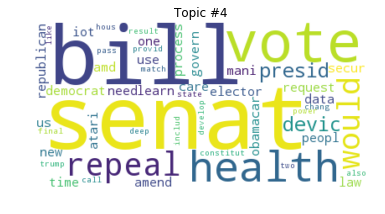

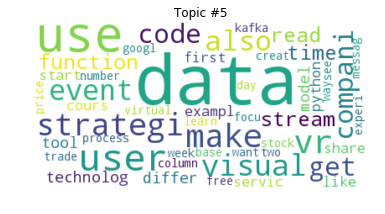

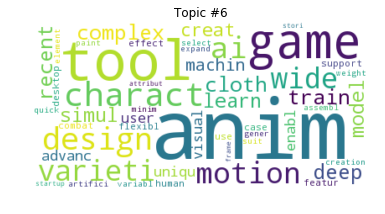

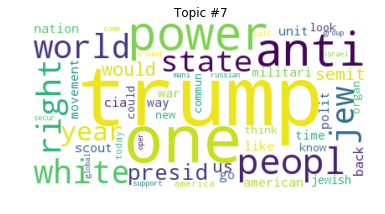

In [46]:
# Plot Top 50 word cloud for 8 topics
plot_word_cloud(lda, lda_feature_names, 50)

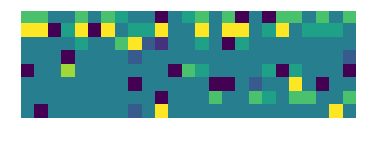

In [47]:
# Plot doucment topic as a image
document_topic = plot_document_topic(lda, X, 25)

In [48]:
document_topic['topic_id'].value_counts()

3    130
5     17
0     17
4     16
7     13
2      5
6      1
1      1
Name: topic_id, dtype: int64

In [49]:
# NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from time import time

tf = TfidfVectorizer(max_features=2000)
t0 = time()
X_2 = tf.fit_transform(corpus)
print("TF-IDF conversion done in %0.3fs." % (time() - t0))

t0 = time()
nmf = NMF(n_components=8, max_iter=10, l1_ratio=.5).fit(X_2)
print("NMF done in %0.3fs." % (time() - t0))
tfidf_feature_names = tf.get_feature_names()


TF-IDF conversion done in 0.197s.
NMF done in 0.022s.


In [50]:
# Examine NMF
# Print Top 20 words for 8 topics
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0:
peopl like would black white one work thing time want feel know could job get even go way tri woman
Topic #1:
data use model scientist scienc insight learn visual user machin algorithm compani predict dataset manag stream column make number process
Topic #2:
senat trump presid bill vote repeal health republican care democrat obamacar scaramucci elector peopl amend constitut state polit power hous
Topic #3:
ai human machin googl learn intellig atari artifici world design paper technolog car creat hype resourc new use game system
Topic #4:
women men wear cloth dress male woman funni lust girl cultur wore stereotyp gay man touch femal fashion cohen say
Topic #5:
sexual sex virgin christian relationship puriti cultur lemk duggar girl gothard shame masturb physic gay bodi pornographi opposit children rule
Topic #6:
vr ar virtual porn experi realiti headset technolog immers smartphon video book app peopl content make devic world vacat applic
Topic #7:
engin leadership softwar slack

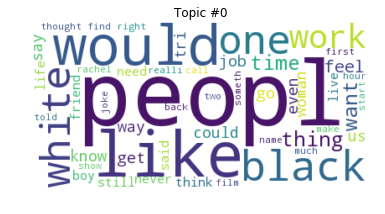

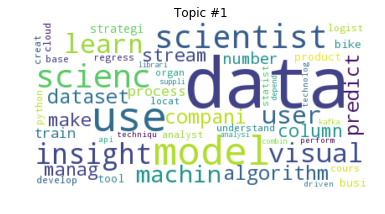

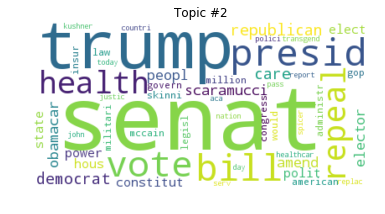

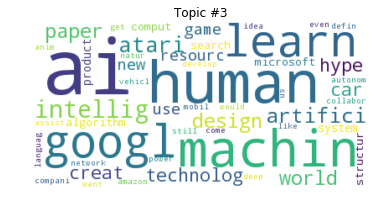

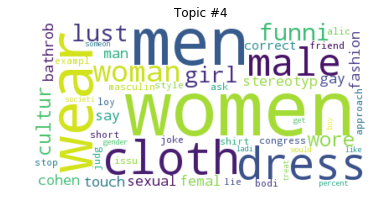

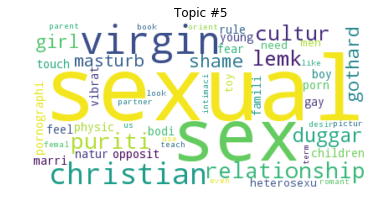

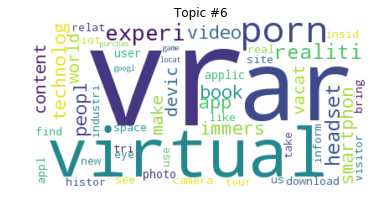

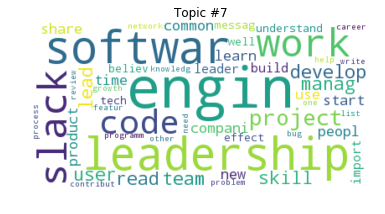

In [51]:
# Plot Top 50 word cloud for 8 topics
plot_word_cloud(nmf, tfidf_feature_names, 50)

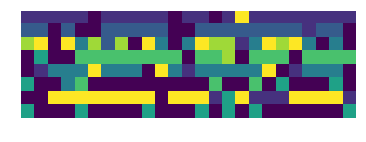

In [52]:
# Plot doucment topic as a image
document_topic2 = plot_document_topic(nmf, X, 25)

In [53]:
document_topic2['topic_id'].value_counts()

0    63
1    31
7    26
3    22
5    20
2    19
4    12
6     7
Name: topic_id, dtype: int64